In [1]:
from os import listdir
from os.path import isdir
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image

In [ ]:
import glob
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## 1 - Load images

In [158]:
covid_dataset = '../../COVID-19'

### 1.1 Method a)

In [4]:
#data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [5]:
#train_ds = data_gen.flow_from_directory(covid_dataset,
                                    target_size=(224,224), color_mode="rgb", class_mode ='binary', batch_size=32, subset="training", shuffle=True)

Found 11047 images belonging to 2 classes.


In [6]:
# validation_ds = data_gen.flow_from_directory(covid_dataset,
#                                     target_size=(224,224), color_mode="rgb", class_mode ='binary', batch_size=32, subset="validation", shuffle=True)

Found 2761 images belonging to 2 classes.


In [7]:
# images, labels = validation_ds.next()

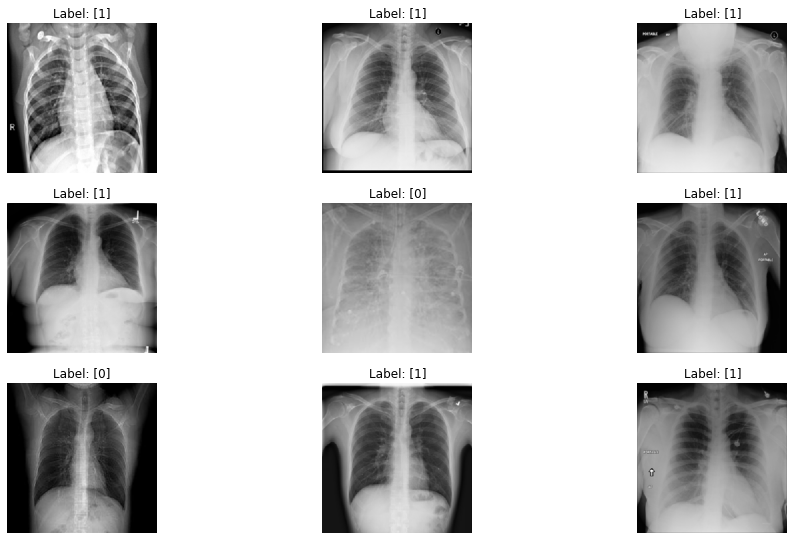

In [8]:
#img = tf.convert_to_tensor(img.reshape(1,150,150,3)) # Imagem em RGB
# plt.figure(figsize=(16,16))
# for i in range(0,9):
#     idx = np.random.choice(np.arange(images.shape[0]),1)[0]
#     img = images[idx]
#     label = labels[idx]
#     label = np.reshape(label, (1,1)).astype('int64')

#     plt.subplot(5,3,(i+1))
#     plt.imshow(np.reshape(img, (224,224,3)), cmap='gray')
#     plt.title("Label: {}".format(label[0]))
#     plt.axis('off')

# plt.show()

## 2 - Build Attack Method (FGSM)

In [113]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

In [4]:
def create_adversarial_pattern(input_image, model,input_label):
  loss_object = tf.keras.losses.BinaryCrossentropy() 
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [122]:
def build_fgsm(image,label, model, eps):
    img_preprocessing = preprocess(image)
    lab = np.reshape(label, (1,1)).astype('int64')
    
    perturbation = create_adversarial_pattern(img_preprocessing, model, lab)
    
    adv_image = image + eps*perturbation
    
    adv_image = tf.clip_by_value(adv_image, 0, 255)
    perturbation = tf.clip_by_value(perturbation, 0, 255)
    
    return adv_image, perturbation

## 3 - Load pre trained model

In [6]:
def read_models(path):
    models_path = glob.glob(path)
    models = dict()
    for m_path in models_path:
        try:
            name = m_path.split("/")[5].replace(".hdf5", "")
            model = tf.keras.models.load_model(m_path)
            models[name] = model
        except Exception as e:
            print("Error in model {}. Error: {}".format(name, str(e)))
            continue
    
    return models

In [7]:
models = read_models('../experiment/Experiment/Models/CNN_mlp_WH_224/*.hdf5')

Error in model ensaio_EfficientNetB0_imagenet_WH_224. Error: Unknown initializer: EfficientNetConvInitializer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
Error in model ensaio_EfficientNetB4_imagenet_WH_224. Error: Unknown initializer: EfficientNetConvInitializer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
Error in model ensaio_InceptionResNetV2_imagenet_WH_224. Error: bad marshal data (unknown type code)


In [8]:
models

{'ensaio_DenseNet201_imagenet_WH_224': <tensorflow.python.keras.engine.functional.Functional at 0x7fe3408a8a90>,
 'ensaio_MobileNetV2_imagenet_WH_224': <tensorflow.python.keras.engine.functional.Functional at 0x7fe33fdc9fd0>,
 'ensaio_NASNetLarge_imagenet_WH_224': <tensorflow.python.keras.engine.functional.Functional at 0x7fe3340e6a00>,
 'ensaio_ResNet50V2_imagenet_WH_224': <tensorflow.python.keras.engine.functional.Functional at 0x7fe2fe3bfbb0>,
 'ensaio_VGG16_imagenet_WH_224': <tensorflow.python.keras.engine.functional.Functional at 0x7fe2fe3bf790>,
 'ensaio_VGG19_imagenet_WH_224': <tensorflow.python.keras.engine.functional.Functional at 0x7fe2fe975ca0>}

### Testando o ataque

In [ ]:
adv_image, perturb = build_fgsm(images[0],labels[0], model_covid, 0.08)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

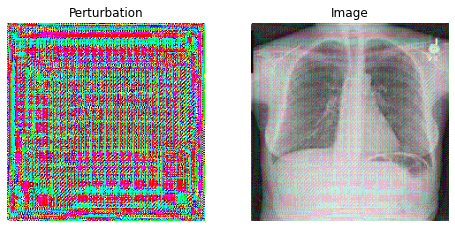

In [179]:
plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(np.reshape(perturb, (224,224,3)))
plt.title("Perturbation")
plt.axis('off')

plt.subplot(222)
plt.imshow(np.reshape(adv_image[0], (224,224,3)))
plt.title("Image")
plt.axis('off')

### Testando com mais images

In [33]:
csv_path = './execution/CSV_Files/test.csv'
csv_data = pd.read_csv(csv_path)

In [106]:
def read_images_from_csv(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224,3),interpolation='bicubic',color_mode = "rgb")
    img = 255.0*np.array(img) / (1.0*np.nanmax(img))
    
    return img 

In [190]:
def gen_fgsm(model, csv_data, base_path, model_path):
    epsilon = [0.01, 0.02, 0.05, 0.08]
    images_path = base_path+"/"+csv_data['folder']+csv_data['image_name']+".png"
    file=0
    for eps in epsilon:
        try:
            path_new = "../attacks/"+model_path+"/eps_" + str(eps)
            if not os.path.exists(path_new): os.makedirs(path_new)
            for img_path, l in zip(images_path, csv_data['label']):
                path_covid = path_new + "/" + "COVID" if l == 1 else path_new + "/" + "NORMAL"
                if not os.path.exists(path_covid): os.mkdir(path_covid)
                fname = path_covid + "/" + "COVID"+str(file)+".png" if l == 1 else path_covid + "/" + "NORMAL"+str(file)+".png"
                img = read_images_from_csv(img_path)
                adv_img, _ = build_fgsm(img,l, model, eps)
                adv_img = tf.convert_to_tensor(adv_img)
                tf.keras.preprocessing.image.save_img(fname, adv_img[0])
                file += 1
        except Exception as e:
            print("Error: "+str(e))

In [188]:
#model_covid = models['ensaio_DenseNet201_imagenet_WH_224']

In [ ]:
for k, model_covid in models.items():
    gen_fgsm(model_covid, csv_data.head(10), covid_dataset, k)